In [1]:
import os 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.functional import interpolate 
import matplotlib.pyplot as plt
from pathlib import Path
import time
# generation imports
from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import param_generation as pg
import _pickle as pickle
from IPython.display import Audio
from feature_extraction.mir_utils import *
from IPython.display import IFrame
###
from PIL import Image
###
import imp
import librosa
import librosa.display
import sys
import csv
from scipy.io.wavfile import write
import threading
from IPython.display import clear_output
import helpers as hp
sys.path.append("..")

import torchaudio
import optuna

import helpers
imp.reload(helpers)
imp.reload(pg)
from feature_extraction import pytorch_models as tm

import IPython
from helpers import *
# from common_vars import SR


drum_names = ['hat', 'kick', 'shake', 'snare']
audio_df = pd.read_csv("csvs/audio_df.csv")
# save_path="./generated_sample_pack/"


import joblib
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

cnet_dvn = tm.Transformer_DVN(attention_dropout=0.3,d_model=120,heads=30,encoding_layers=12,pool_dim=2,)
cnet_dvn = cnet_dvn.load_from_checkpoint(
    "models/transformer/DVNepoch=41-val_accuracy=0.991-val_loss=0.048.ckpt")

cnet_dvd = tm.Transformer_DVD(attention_dropout=0.3,d_model=100,heads=20,encoding_layers=12,pool_dim=1,pct_start=0.05,max_lr=1e-4,max_momentum=0.95,epochs=50)
cnet_dvd = cnet_dvd.load_from_checkpoint(
    "models/transformer/DVDepoch=59-val_accuracy=0.917-val_auc=0.9779-val_loss=0.327.ckpt")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnet_dvn.to(device)
cnet_dvd.to(device)
pass 



In [2]:
####
#defining transformations
spec=torchaudio.functional.spectrogram
FREQ_BINS=30
TIME_STEPS=100
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):
    def __init__(self,num_mels=10,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        
        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//20
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)
#         s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}
        

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR,time_steps=20):
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf,label,p,drum_type=sample["signal"],sample["label"],sample["path"],sample["drum_type"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
        s= self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()
        freq=s
        freq[torch.isnan(freq)]=0
        freq=freq[0]
        return {"feats":freq.detach(),"label":label,"path":p,"drum_type":drum_type}

def MakeSpecs(tfList, plt,a_sample):
    for i, tsfrm in enumerate(tfList):
        transformed_sample = tsfrm(a_sample)
        ax = plt.subplot(1, 3, i + 1)
        plt.tight_layout()
        ft=transformed_sample["feats"]
        if i==0:
            plt.title("Frequency Features",fontsize=20)
            plt.xlabel("Frequency Bin",fontsize=20)
            plt.ylabel("Scaled Magnitude",fontsize=20)
            plt.scatter(y=ft,x=range(0,len(ft)))
        if i==1:
            plt.title("Envelope Features",fontsize=20)
            plt.xlabel("Time Step",fontsize=20)
            plt.ylabel("Scaled Magnitude",fontsize=20)            
            plt.scatter(y=ft,x=range(0,len(ft)))
        if i==2:
#             print(ft.shape,)
            sf=ft.detach().numpy()
            ft=ft.detach().numpy()
            plt.title("Spectrum Features",fontsize=20)
            librosa.display.specshow(sf,cmap='gray_r',)
            plt.xlabel("Time Step",fontsize=20)
            plt.ylabel("Magnitude of Bin",fontsize=20)


def sample_sound():
    df = audio_df[audio_df["maj"]=="drums"]
    random_row = np.random.randint(len(df))
    row = df.iloc[random_row]
    audio = librosa.load(row["path"])[0]
    major,minor = row["maj"],row["min"]
    return {"signal":torch.tensor(audio),"label":major,"path":'',"drum_type":minor}

def space_to_sound(params):
    program = pg.StackParams()
    program.__dict__ = dict(zip(program.__dict__.keys(),params.values()))
    out = dsp.buffer(length=1,channels=1)
    s = pg.Synth(program)
    out.dub(s.buff,program.getStart())
    out = fx.norm(out,1)
    sound = hp.memToAud(out)

    signal = torch.tensor(librosa.resample(sound.reshape(-1),SR,SR//2)).to(device)[0:SR//4].reshape(1,-1)
    return signal,sound

# make sound and evaluate
def make_and_eval(stack_size = 1):
    out,params = StackMaker(stack_size)
    a = memToAud(out)
    try:
        signal = torch.tensor(librosa.resample(a.reshape(-1),SR,SR//2))[0:SR//4]
    except Exception as e:
        signal = torch.tensor(np.zeros([1,1,SR//4])).float()
    with torch.no_grad():
        cnet_dvn.eval()
        ps_dvn = cnet_dvn(signal.reshape(1,-1).to(device))
        ps_dvd = cnet_dvd(signal.reshape(1,-1).to(device))
        
#         print(dict(zip(drum_types,ps_dvd[0].numpy())))
    return a,signal,ps_dvn.cpu(),ps_dvd.cpu()

In [3]:
%%HTML
<style>



.container {
    width: 95% !important;
}

.rendered_html {
  font-size:1.4em;
}
.rise-enabled .reveal .slides
 {

    font-size: 30px;
#     font-family: "Hiragino Kaku Gothic ProN", Meiryo, sans-serif;
#     font-family: "Ricty", monospace;
 }
.reveal .slide-number {
  font-size: 25pt;
  color: rgb(0,0,255); 
}

</style>

<center>
Percussive Sound Generation with Virtual Listeners and Modular Synthesizers
</center>

Candidate: Amir Salimi

Supervisor: Abram Hindle

MSc. Thesis Seminar

#### Motivation and Background:
- We want to create one-shot drum sounds
    - One-shot drum sounds are isolated sounds
    - Used by musicians to make drum-tracks

In [15]:
%%HTML
<audio controls><source src="./presentation_files/audio_files/kick03.ogg"></audio>
<audio controls><source src="./presentation_files/audio_files/clap03.ogg"></audio>
<audio controls><source src="./presentation_files/audio_files/hihat_closed03.ogg"></audio>
<audio controls><source src="./presentation_files/audio_files/shaker02.ogg"></audio>

In [5]:
%%HTML
</audio><audio controls><source src="./presentation_files/audio_files/loop1.wav"></audio>

In [6]:
%%HTML
</audio><audio controls><source src="./presentation_files/audio_files/loop2_1.wav"></audio>

- How to find new drums?
    - Live recordings
    - Sound engineering
    - Purchasing

- How to find new drums?
    - Recording instruments

- How to find new drums?
    - Buying sounds

<center><img src="./presentation_files/buying_drums_big.png" width="1200"/>
<font size="6"> Source: https://www.image-line.com/fl-studio/samples-loops-presets/ </font></center>

- How to find new drums?
    - Sound engineering

<center> <img src="https://static.kvraudio.com/i/b/flstudio20_produceredition_windows.jpg" width="1300">
<font size="6"> Fl-Studio, a Digital Audio Workstation (DAW) </font>
</center>


<center><img src="https://cdn.mos.cms.futurecdn.net/sd3xh9upEnLLkbkTpyUMjL.jpg" width="1250">
<font size="6"> Virtual Studio Technology (VST) plug-ins </font></center>

<font size=12>
Perhaps computers can be used to make drum-kits with low cost?
</font>
<br>
<font size=12>
    - Computers can make sounds<br>
    - Computers can classify sounds<br>
    - Can we combine these capabilities?
</font>

Computers can be programmed to make sounds
- Digital signal processing (DSP)
- Neural networks

How can virtual listening be accomplished?
- Machine learning
    - Raw digital sounds are hard to learn from
    - Requires feature extraction
- Fourier transforms are popular

<center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/c/c5/Spectrogram-19thC.png" width="1200">
 <a><font size="6"> Public Domain Image, by user Aquegg:
     https://en.wikipedia.org/wiki/Spectrogram#/media/File:Spectrogram-19thC.png </font></a></center>

| Work                                        | Features| Synthesis                 | Specilization |
|---------------------------------------------|--------------------|---------------------------|---------------|
| Oord et al.[1]           | CNN                | CNN                       | Speech       |
| Aouameur et al.[2]   | Latent layer       | Decoding of Latent Layers | Percussion    |
| Ramires et al.[3]     | Latent layer       | FeedForward Network       | Percussion    |


<font size="4"> [1] Aaron van den Oord, Sander Dieleman, Heiga Zen, Karen Simonyan, Oriol Vinyals, Alex Graves, Nal Kalchbrenner, Andrew Senior, and Koray Kavukcuoglu. Wavenet: A generative model for raw audio.arXiv:1609.03499, 2016.<br>
[2] Cyran Aouameur, Philippe Esling, and Gaetan Hadjeres. Neural drum machine: An interactive system for real-time synthesis of drum sounds. arXiv:1907.02637, 2019.<br>
[3]Antonio Ramires, Pritish Chandna, Xavier Favory, Emilia Gomez, and Xavier Serra. Neural percussive synthesis parameterised by high-level timbral features. In ICASSP 2020-2020 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), pages 786–790. IEEE, 2020. 
</font>
</p>

#### Methodology: Two Components
- Virtual Synthesizer: Use software synthesis to make sounds
- Virtual Ear: Use virtual listening to extract drum-like sounds from synthesized sounds

<center><img src="./presentation_files/pipeline.png" width="1300">
</center>
<center>
<font size="6"> Generative System of Sounds 
</font>
</center>




#### Goal of Thesis:
1. Creation of one-shot drum samples with virtual synthesizers and virtual ears.
2. Majority of sounds generated can be used as one-shot percussive sounds

#### What was done in this work:
<sub>
1. Virtual synthesizers: Creation of sounds using digital signal processing<br>
2. Virtual Ear: Implementation virtual listeners that can detect drums<br>
3. Curation of a free datasets of drum sounds (for learning)<br>
4. Generative system of drums using virtual listeners and synthesizers<br>
5. Blinded survey of the outputs<br>


### Virtual Synthesis

<center><img src="presentation_files/synthesizer_block.png" width="1000" height="1200"></center>
<center>
<font size="6"> Synthesizer block (sub-module)
</font>
</center>


### Synthesizer block Parameters:
| Parameters       | Value Range     | Notes and Constraints                            |
|------------------|-----------------|--------------------------------------------------|
| Attack           | 0\-3            | A\-D\-S\-R values relative                       |
| Decay            | 0\-3            | relative to A\-S\-R                              |
| Sustain          | 0\-3            | relative to A\-D\-R                              |
| Release          | 0\-3            | relative to A\-D\-S                              |


<center><img src="https://upload.wikimedia.org/wikipedia/commons/e/ef/ADSR_Envelope_Graph.svg" width="1200" height="800">
</center>
<center>
<font size="5">Licensed under CC BY-SA 3.0, by wikimedia user Abdull: https://commons.wikimedia.org/wiki/File:ADSR_parameter.svg</font>
</center>

<sub>
Synthesizer block Parameters:<br>
    
| Parameters       | Value Range     | Notes and Constraints                            |
|------------------|-----------------|--------------------------------------------------|
| OSC type         | sine,square,saw | \-                                               |
| IsNoise          | boolean         | generate noise by clouding the waveform |
| Length           | 0\-1 second     | \-                                               |
| StartTime        | 0\-1 second     | Length\+Start$<$1                                |
| Amplitude        | 0\.1\-1         | 1 = max amplitude                                |
| Pitches\(notes\) | list of pitches | range of C0\(16\.35hz\) to B9                    |
| HP filter Cutoff | 0\-20000hz      | \-                                               |
| LP filter Cutoff | 0\-20000hz      | never lower than HP cutoff                       |
| Filter Order     | 4,8,16          | butterworth filter order                         |


<center><img src="presentation_files/synthesizer_all_blocks.png" width="1000"></center>
<center>
<font size="7">Virtual synthesizer, stack size determines how many synthesizer blocks are used</font>
</center>


In [18]:
### What do the programs look like?
params,stack_num = [],3
params = [pg.RandomParams() for i in range(stack_num)]
for p in params:
    print(p.__dict__)

{'oscType': 0, 'isNoise': 0, 'A': 1, 'D': 1, 'S': 2, 'R': 2, 'pitch_0': 54, 'pitch_1': 24, 'pitch_2': 48, 'pitch_3': 80, 'bpCutLow': 90, 'bpCutHigh': 115, 'bpOrder': 0, 'amplitude': 1, 'start': 9, 'length': 0, 'em_prob': 0.75, 'fm_prob': 0.5}
{'oscType': 0, 'isNoise': 1, 'A': 1, 'D': 3, 'S': 3, 'R': 1, 'pitch_0': 22, 'pitch_1': 108, 'pitch_2': 56, 'pitch_3': 0, 'bpCutLow': 94, 'bpCutHigh': 100, 'bpOrder': 2, 'amplitude': 3, 'start': 3, 'length': 1, 'em_prob': 0.25, 'fm_prob': 0.25}
{'oscType': 0, 'isNoise': 1, 'A': 0, 'D': 1, 'S': 2, 'R': 3, 'pitch_0': 76, 'pitch_1': 28, 'pitch_2': 88, 'pitch_3': 80, 'bpCutLow': 34, 'bpCutHigh': 111, 'bpOrder': 1, 'amplitude': 0, 'start': 5, 'length': 2, 'em_prob': 0.5, 'fm_prob': 0.25}


CPU times: user 142 ms, sys: 8.22 ms, total: 151 ms
Wall time: 121 ms


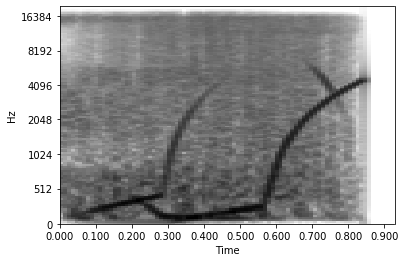

In [25]:
%%time
out = dsp.buffer(length = 1, channels = 1)
params,stack_num = [], 16
params = [pg.RandomParams() for i in range(stack_num)]
sound = pg.ensemble(params)
hp.get_mel_spec(sound)
Audio(sound,rate = sr, autoplay = 0)

### So... we can make noise. What now?
- But how do we select ones that sound the most like drums?
- We need a virtual ear which can make two decisions:
    - Decision 1: Recognizes drums from not-drums
    - Decision 2: Given a drum, categorize type

### Maybe these datasets can help
| DB Name     | Categories                                                            |
|-------------|-----------------------------------------------------------------------|
| FreeDB      | Kicks:533 - Snares:372 - Claps:230 - Hats:105 - Other:281             |
| RadarDB     | Kicks:1054 - Snares:842 - Claps:353                         |
| MixedDB     | Kicks:648 - Snares:732 - Claps:179 - Hats:105 - Toms:416 - Others:281 |
| NoiseDB     | 1 Stack:2000 - 3 Stacks:2000 - 5 Stacks:2000                          |



## 4: Virtual Ears
- Took two different approaches to represent sounds
- Representation type led to two approaches to virtual ears:
    - Two Phased Ears (TPEs)
    - Mixed Ear Models (MEMs)

### Sound Representation
- Why is it needed?
    - Audio signals have many datapoints
    - More general models
- Common methods?
    - Fourier transforms, wavelets, etc.

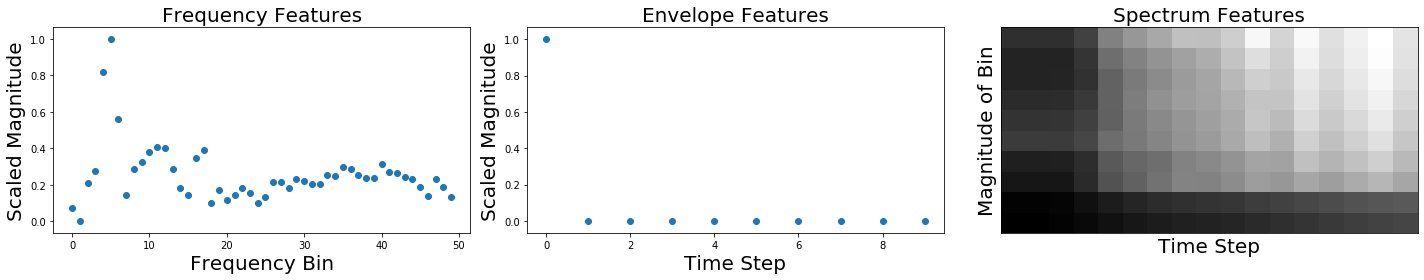

In [29]:
fig = plt.figure(figsize=(20,4))
sample = sample_sound()
tfList=[freqTrans(50),envTrans(num_mels=10,SR=SR),specTrans(10,time_steps=TIME_STEPS)]
MakeSpecs(tfList, plt,sample)
Audio(sample["signal"],rate=SR//2,autoplay=0)

#### What can we learn from these features?
- We need a virtual ear to make two decisions
    - Decision 1: Drum vs Not Drum
    - Decision 2: Different types of drums

#### Virtual Ears Types:
- Two Phased Ears:
   - Different ears specialize and work sequentially
   - Decision 1, then Decision 2
- Mixed Ear Models:
    - Further condense the representation and make both decisions together

Two Phased Ears (TPEs):

<center>
<img src="./presentation_files/TPE_ear_fixed2.png" width="1000">
</center>
<center>
<font size="6">Two Phased Ear</font>
</center>

#### Different TPE Architectures:
- TPEs that specialize in decision 1: FC-DVN, CNN-DVN
- TPEs that specialize in decision 2: FC-DVD, CNN-DVD, E+F-DVD
- All TPEs used here showed high accuracy on test sets

FC-DVN:

| Layer-\# | Output Shape               | Details           |
|----------|----------------------------|-------------------|
| Linear-1 | [600]       | Input Layer       |
| PReLU    | [600]       |                   |
| Linear-2 | [20]        |                   |
| PReLU    | [20]        |                   |
| Linear-3 | [10]        |                   |
| Linear-3 | [4]         |                   |
| Softmax  | [2] | DvN Probabilities |

CNN-DVN:

| Layer-\#  | Output Shape               | Details           |
|-----------|----------------------------|-------------------|
| Conv2d-1  | [1, 30, 20] |                   |
| ReLU-2    | [1, 30, 20] |                   |
| Dropout-4 | [1, 15, 10] |                   |
| LSTMCell  | [30]        | hidden size:800   |
| Linear-1  | [2]         |                   |
| Softmax   | [2]         | DVN probabilities |


E+F-DVD

| Layer-\# | Output Shape                | Details                           |
|----------|-----------------------------|-----------------------------------|
| Linear-1 | [60]         | 10 Envelope + 50 Frequency Features |
| PReLU    | [60]         |                                   |
| Linear-2 | [30]         |                                   |
| PReLU    | [30]         |                                   |
| Linear-3 | [10]         |                                   |
| Linear-3 | [10]         |                                   |
| Softmax  | [Drum Types] | DvD Probabilities                 |



#### Mixed Ear Models:

<center>
<img src="./presentation_files/autoencoder2.png" width="1200" height="1400">
</center>
<center>
<font size="6">Spectrogram AutoEncoder</font>
</center>

<center>
<img src="./presentation_files/MEM_ear_fixed.png" width="1400" height="1200">
</center>
<center>
<font size="6">Mixed-ear Model (MEM)</font>
</center>

#### Projecting encodings used by MEM: 

<center><img src="./presentation_files/t-SNE_2d.png" width="750"></center>
<center>
<font size="5">T-SNE Projections</font>
</center>

### MEM uses embeddings to classify sounds:
- We compare CV accuracy of models trained with embeddings+envelope features
- Classification labels: snare,kick,hat,clap or synthesized sound

<center>
<img src="./presentation_files/mme_comparisons_mme.png" width="1500" height="1200">
<center>
<font size="6">MEM comparisons</font>

#### How a System is Put Together

<center><img src="./presentation_files/pipeline.png" width="1300" height="1200"></center>
<center>
<font size="6"> Generative System of Sounds 
</font>

In [38]:
#5.1 Finding drums via random sound generation
acceptance_threshold = 1.5
for i in range(300):
    synth_out,a,ps,ps_dvd = make_and_eval(2)
    a = a.reshape([-1]).cpu().numpy()[0:SR//4]
    print("number of random programs:",i,end="\r")
    if ps[0].item() > acceptance_threshold:
        clear_output()
        print("number of random programs:",i)
        print(drum_names[np.argmax(ps_dvd)],"with score: %f"%ps[0].item())
        break
Audio(a,rate=SR//2,autoplay=0)


number of random programs: 5
hat with score: 3.319649


### 5. Survey and Results 
- 5.1 How are surveys done?
- 5.2 TPE Surveys
- 5.3 MEM surveys
- 5.4 Survey Comparisons

### Fleiss Kappa Coefficients for  TPE Survey
| Drop Rule                           | Size | H\+H   | H\+FC | H\+CNN | H\+E/F |
|-------------------------------------|------|-------|-------|--------|--------|
| No Samples Removed                           | 257  | 0\.37 | 0\.35 | 0\.36  | 0\.36  |
| Assigned "Bad" or "Other" By Either | 154  | 0\.47 | 0\.59 | 0\.54  | 0\.50  |


### Fleiss Kappa Coefficients for MEM Survey
| Drop Rule                           | Size | HvH    | H\+MEM |
|-------------------------------------|------|--------|--------|
| No Samples Removed                             | 300  | 0\.336 | 0\.250 ||
| Assigned "Bad" or "Other" By Either | 120  | 0\.620 | 0\.587 |

### What can we learn from these surveys?
- Decision 1: The sounds generated were deemed percussive by both subjects in 70% of the cases with the TPE system, and 50% with the MEM. 
- Decision 2 is also not perfect
- Both systems can generate drums 50+% of the time

### 6. Drum Kit Mutation: An Exercise
- Can our systems be used to make drum-kits?
- Can we make drum-kits during live performances?

<center><img src="./presentation_files/live_programming.png" width="1200" height="1200"></center>


#### Drum Programs:
| Program  | BPM | Beats | Action at Each Beat                                        |
|----------|-----|-------|------------------------------------------------------------|
| Loop 1   | 180 | 8     | Kick-Snare-Hat-Kick-Snare-Hat-Kick-Shake                   |
| Loop 2   | 125 | 16    | Kick-.-Kick-.-Snare-.-Hat-Shake-Hat-Shake-Kick-.-Snare-.-. |

#### Survey:
| Program | Listener 1 Likes/100 | Listener 2 Likes/100 | Average Percentage |
|---------|----------------------|----------------------|--------------------|
| Loop 1  | 73/100               | 54/100               | 68\%               |
| Loop 2  | 55/100               | 55/100               | 55\%               |



#### Good and Bad Examples:
- Full sets can be downloaded on zenodo

#### Good and bad examples for program 1

In [11]:
print("Program 1 - Good")
IPython.display.display(Audio(librosa.load("./presentation_files/audio_files/program1_good1.wav")[0],rate=SR//2))
IPython.display.display(Audio(librosa.load("./presentation_files/audio_files/program1_good2.wav")[0],rate=SR//2))
print("Program 1 - Bad")
IPython.display.display(Audio(librosa.load("./presentation_files/audio_files/program1_bad1.wav")[0],rate=SR//2))
IPython.display.display(Audio(librosa.load("./presentation_files/audio_files/program1_bad2.wav")[0],rate=SR//2))

Program 1 - Good


Program 1 - Bad


Good and bad examples for program 2:

In [12]:
print("Program 1 - Good")
IPython.display.display(Audio(librosa.load("./presentation_files/audio_files/program2_good1.wav")[0],rate=SR//2))
IPython.display.display(Audio(librosa.load("./presentation_files/audio_files/program2_good2.wav")[0],rate=SR//2))
print("Program 1 - Bad")
IPython.display.display(Audio(librosa.load("./presentation_files/audio_files/program2_bad1.wav")[0],rate=SR//2))
IPython.display.display(Audio(librosa.load("./presentation_files/audio_files/program2_bad2.wav")[0],rate=SR//2))

Program 1 - Good


Program 1 - Bad


### 7. Search (work in progress)
- Only random search was used in this work
- Searching the paramter space can speed up generation

#### First attempt at search:
- Stack size of 1 only
- Hyper-parameter optimization on the synthesizer's paramters
    - We have a multivariate space to sample parameters from

- Treat the ear's scores as the value we're trying to maximize
    + -1 if not a valid paramter set
    + 0 if not a drum (decision 1 TPE probability <0.5)
    + 0-1 if the sound is a drum (probability output of decision 2 TPE)
    + create a gaussian parameter space which we can sample from
    + 5000 trials to create the distribution

In [13]:
# select a space to sample from
drum_names = ['hat', 'kick', 'shake', 'snare']
dt = 0
study_name = "HyperBand_%s"%drum_names[dt]
study = joblib.load("studies/%s_study.pkl"%study_name)
space = optuna.samplers.intersection_search_space(study)

In [14]:
num_invalids = 0
for i in range(100):
    print(i,end="\r")
    try:
        params = study.sampler.sample_relative(study,optuna.trial._frozen.FrozenTrial,space)
        signal,sound = space_to_sound(params)
        cnet_dvn.eval(),cnet_dvd.eval()
        with torch.no_grad():
            score_dvn = cnet_dvn(signal).item()
            score_dvd = cnet_dvd(signal)[0][dt].item()
        if (score_dvn < 0 or score_dvd < 1):
            pass
        else:
            print("attempt->%d, invalid programs->%d\n"%(i,num_invalids))
            print(score_dvn,score_dvd)
            break
    except Exception as e:
        num_invalids += 1
        pass 
Audio(sound,rate=SR, autoplay=0)

attempt->1, invalid programs->0

6.189540863037109 6.084634304046631


### Conclusion 
- We implemented a virtual synthesizer and virtual ears
- We made them work together to create drum sounds
- Computational overhead is fairly small
    - Sound generation is quick
    - Models are small and train quickly
- Both approaches produce drum samples but...

### Future Work
1. There are a lot of "duds" mixed in, possible solutions:
    - Open set recognition
    - Scalable heuristic search 
2. A lot of the produced samples sound the same. 
    - Different approaches to sound synthesis can be taken


<center><img src="./presentation_files/questions.png" width="1300"></center>
<center>
    <font size = 10>Thank you
    </font>
</center>